<div class="alert alert-success">
    <center> <h1> <font size="8"> Multivariate Student-T Example </font> </h1> </center>
    <center> <h1> <font size="5"> Cholesky Decomposition of Covariance Matrix $\Sigma$  </font> </h1> </center>
</div>

<br/>
<br/>

In this example, we model and predict all parameters of a trivariate ($Y_{D}=3$) Student-T distribution. As a generalization of the multivariate Normal, the multivariate Student-T is suitable when modelling heavy-tailed data, i.e., when there is more mass in the tails of the distribution. The multivariate Student-T distribution has an additional degrees of freedom parameter $\mathbf{\nu}_{\mathbf{x}} > 2$ that governs the tail behaviour, where for $\mathbf{\nu}_{\mathbf{x}} \rightarrow \infty$ the Student-T converges in distribution to the multivariate Normal. The conditional means $\mathbf{\mu}(x) \in \mathbb{R}^{D}$ and the conditional covariance matrix $\mathbf{\nu}(x)\big(\mathbf{\nu}(x)-2\big)^{-1}\mathbf{\Sigma}(x) \in \mathbb{R}^{D \times D}$ are given as follows

$$
\mathbf{\mu}(x)=\begin{pmatrix}\mu_{1}(x) \\ \mu_{2}(x) \\ \mu_{3}(x)\end{pmatrix}, \qquad \qquad  
\mathbf{\Sigma}(x)= \begin{pmatrix}
\sigma^{2}_{11}(x) & \rho_{1,2}(x)\sigma_{1}(x)\sigma_{2}(x) & \rho_{1,3}(x)\sigma_{1}(x)\sigma_{3}(x) \\
\rho_{2,1}(x)\sigma_{2}(x)\sigma_{1}(x) & \sigma^{2}_{22}(x) & \rho_{2,3}(x)\sigma_{2}(x)\sigma_{3}(x) \\
\rho_{3,1}(x)\sigma_{3}(x)\sigma_{1}(x) & \rho_{3,2}(x)\sigma_{3}(x)\sigma_{2}(x) &  \sigma^{2}_{33}(x)
\end{pmatrix}
$$

where $\mathbf{\mu}(x)$ and $\mathbf{\Sigma}(x)$ are defined as for the multivariate Normal. To ensure positive definiteness of $\Sigma(\cdot)$, the $D(D + 1)/2$ entries of the covariance matrix must satisfy specific conditions. For the bivariate case, this can be ensured by applying exponential functions to the variances and a suitable transformation to restrict the coefficient of correlation $\rho \in [-1,1]$. However, in high-dimensional settings, where all moments are modelled as functions of covariates, ensuring positive definiteness of the covariance matrix becomes challenging, since joint restrictions for the elements are necessary. A computationally more tractable approach to ensure positive definiteness is based on the Cholesky decomposition, that uniquely decomposes the covariance matrix as follows

$$
\mathbf{\Sigma}(x) = \mathbf{L}(x) \mathbf{L}^{\prime}(x)
$$

where $\mathbf{L}(\cdot) \in \mathbb{R}^{D \times D}$ is a lower triangular matrix. To ensure $\mathbf{\Sigma}(\cdot)$ to be positive definite, the $D$ diagonal elements $\ell_{ii}$ of
$\mathbf{L}(\cdot)$ need to be strictly positive, whereas all $D(D −1)/2$ off diagonal elements $\ell_{ij}$ can take on any value. For the trivariate case, the Cholesky factor $\mathbf{L}(\cdot)$ is given as follows

$$
\mathbf{L}(x)= \begin{pmatrix}
\exp\big(\ell_{11}(x)\big) & 0 & 0 \\
\ell_{21}(x) & \exp\big(\ell_{22}(x)\big) & 0 \\
\ell_{31}(x) & \ell_{32}(x) & \exp\big(\ell_{33}(x)\big)\\
\end{pmatrix}
$$

Given the usefulness of the Cholesky decomposition, instead of estimating the entries of $\mathbf{\Sigma}(\cdot)$ directly, Py-BoostLSS estimates the Cholesky factors $\mathbf{L}(\cdot)$ and then uses these for creating $\mathbf{\Sigma}(\cdot)$. However, in contrast to the original formulation of $\mathbf{\Sigma}(\cdot)$, the elements in $\mathbf{L}(\cdot)$ do not have any direct interpretation. For more details, we refer to our related paper **[März, Alexander (2022), *Multi-Target XGBoostLSS Regression*](https://arxiv.org/abs/2210.06831)**.

<br/>
<br/>

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
# Optional: set the device to run
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from pyboostlss.model import *
from pyboostlss.distributions.MVT import *
from pyboostlss.distributions.distribution_loss_metric import *
from pyboostlss.utils import *
from pyboostlss.datasets.data_loader import load_example_data

import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

# Specifiy distribution and initialize model

In [2]:
distribution = MVT(D=3)             # Multivariate Student-T distribution, where D specifies the number of target variables
pyblss = PyBoostLSS(distribution)   # Initializes model with specified distribution

# Data

In [3]:
data_sim = load_example_data("sim_triv_student.csv")

# Create 60%, 20%, 20% split for train, validation and test 
train, validate, test = np.split(data_sim.sample(frac=1,random_state=123), [int(0.6*len(data_sim)), int(0.8*len(data_sim))])

# Train
x_train = train.filter(regex="x").values
y_train = train.filter(regex="y").values
dtrain = {"X": x_train, "y": y_train}

# Validation
x_eval = validate.filter(regex="x").values
y_eval = validate.filter(regex="y").values
eval_sets = [{'X': x_eval, 'y': y_eval}] # Specifies eval_sets on which the model is evaluated on

# Test
x_test = test.filter(regex="x").values
y_test = test.filter(regex="y").values

# Hyper-Parameter Optimization via Optuna

In [4]:
np.random.seed(123)

# Specifies the hyper-parameters and their value range
    # The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]
    # Currently, only the following hyper-parameters can be optimized
    
hp_dict = {"lr": [1e-3, 1],  
           "max_depth": [1, 4],
           "sketch_outputs": [1,10],
           "lambda_l2": [0, 40],     
           "colsample": [0.2, 1.0],
           "subsample": [0.2, 1.0],
           "min_gain_to_split": [0, 500]
          }  

opt_param = pyblss.hyper_opt(params=hp_dict,
                             dtrain=dtrain,
                             eval_sets=eval_sets,
                             use_hess=True, 
                             sketch_method="proj",
                             seed=123,                   # Model seed
                             hp_seed=123,                # Seed for random number generator used in the Bayesian hyper-parameter search.
                             ntrees=500,                 # Number of boosting iterations.
                             es=20,                      # Early stopping rounds
                             n_trials=50,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             max_minutes=120,            # Time budget in minutes, i.e., stop study after the given number of minutes.
                             silence=False)              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

[I 2022-12-08 16:48:54,026] A new study created in memory with name: Py-BoostLSS Hyper-Parameter Optimization
C:\Users\Alexander\.julia\v0.6\Conda\deps\usr\envs\pyboost\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/50 [00:00<?, ?it/s]

[16:49:05] Stdout logging level is INFO.
[16:49:05] GDBT train starts. Max iter 500, early stopping rounds 20
[16:49:11] Iter 0; Sample 0, NLL-score = 10211.33485567945; 
[16:49:17] Early stopping at iter 80, best iter 60, best_score 8658.331371863578
[I 2022-12-08 16:49:17,857] Trial 0 finished with value: 8658.33203125 and parameters: {'lr': 0.6967727164122638, 'max_depth': 2, 'sketch_outputs': 3, 'lambda_l2': 22.05259076331565, 'colsample': 0.7755751758284506, 'subsample': 0.5384851680995688, 'min_gain_to_split': 490.38209919230775}. Best is trial 0 with value: 8658.33203125.
[16:49:18] Stdout logging level is INFO.
[16:49:18] GDBT train starts. Max iter 500, early stopping rounds 20
[16:49:18] Iter 0; Sample 0, NLL-score = 10111.75265364621; 
[16:49:23] Early stopping at iter 61, best iter 41, best_score 8687.20014465595
[I 2022-12-08 16:49:23,462] Trial 1 finished with value: 8687.2001953125 and parameters: {'lr': 0.6851449088462784, 'max_depth': 2, 'sketch_outputs': 4, 'lambda_l2

# Model Training

In [5]:
opt_params = opt_param.copy()

pyboostlss_model = pyblss.train(dtrain=dtrain,
                                lr=opt_params["lr"], 
                                lambda_l2=opt_params["lambda_l2"],
                                max_depth=opt_params["max_depth"],
                                sketch_outputs=opt_params["sketch_outputs"],
                                colsample=opt_params["colsample"],
                                subsample=opt_params["subsample"],
                                min_gain_to_split=opt_params["min_gain_to_split"],
                                ntrees=opt_params["opt_rounds"],
                                use_hess=True,
                                verbose=100,                                
                                sketch_method="proj",
                                seed=123)

[17:05:48] Stdout logging level is INFO.
[17:05:48] GDBT train starts. Max iter 197, early stopping rounds 100
[17:05:49] Iter 0; 
[17:05:57] Iter 100; 
[17:06:04] Iter 196; 


# Predict

In [6]:
# Predicts transformed parameters of the specified distribution. Py-BoostLSS returns the elements of the covariance matrix, instead of the Cholesky factors.
predt_params = distribution.predict(model=pyboostlss_model,
                                    X_test=x_test,
                                    pred_type="parameters")
predt_params

,df,location_1,location_2,location_3,scale_1,scale_2,scale_3,rho_21,rho_31,rho_32
0,8.512745,1.153811,0.236611,0.967043,1.413578,0.705988,1.885383,0.726707,0.472277,0.302976
1,4.800871,0.378471,-0.248724,1.918573,2.058549,0.914443,2.272370,0.501279,0.634854,0.643743
2,3.411268,0.915803,0.662983,1.334326,1.704603,1.681773,3.006747,0.482754,0.937053,0.709487
3,3.435819,0.404853,0.170475,2.571147,1.717155,1.702141,2.510855,0.608926,0.943689,0.740405
4,4.066855,0.843109,0.178655,1.204540,1.931859,1.199751,2.413158,0.439340,0.848642,0.637501
...,...,...,...,...,...,...,...,...,...,...
1995,16.453375,-0.016146,-0.100414,1.991234,1.110066,0.595075,1.166914,0.708536,0.363896,0.585511
1996,5.059857,0.386414,-0.194361,1.849165,2.006048,0.878280,2.195301,0.514775,0.661060,0.659520
1997,3.472135,0.914079,0.662844,1.328134,1.683017,1.647635,2.973619,0.484099,0.936352,0.712665
1998,8.525260,1.420602,0.069592,0.913828,1.466704,0.715965,1.742784,0.710052,0.518608,0.351180


In [7]:
# Draws random samples from the predicted distribution
torch.manual_seed(123)
n_samples = 10000
predt_samples = distribution.predict(model=pyboostlss_model,
                                     X_test=x_test,
                                     pred_type="samples",   
                                     n_samples=n_samples)

predt_samples.shape # Output-shape is (n_samples, n_obs, n_target)

(10000, 2000, 3)

# Plots

## Actual vs. Predicted Parameters

In the following figure, we compare the true parameters of the multivariate Student-T with the ones predicted by Py-BoostLSS. The below figure shows that the estimated parameters closely match the true parameters.

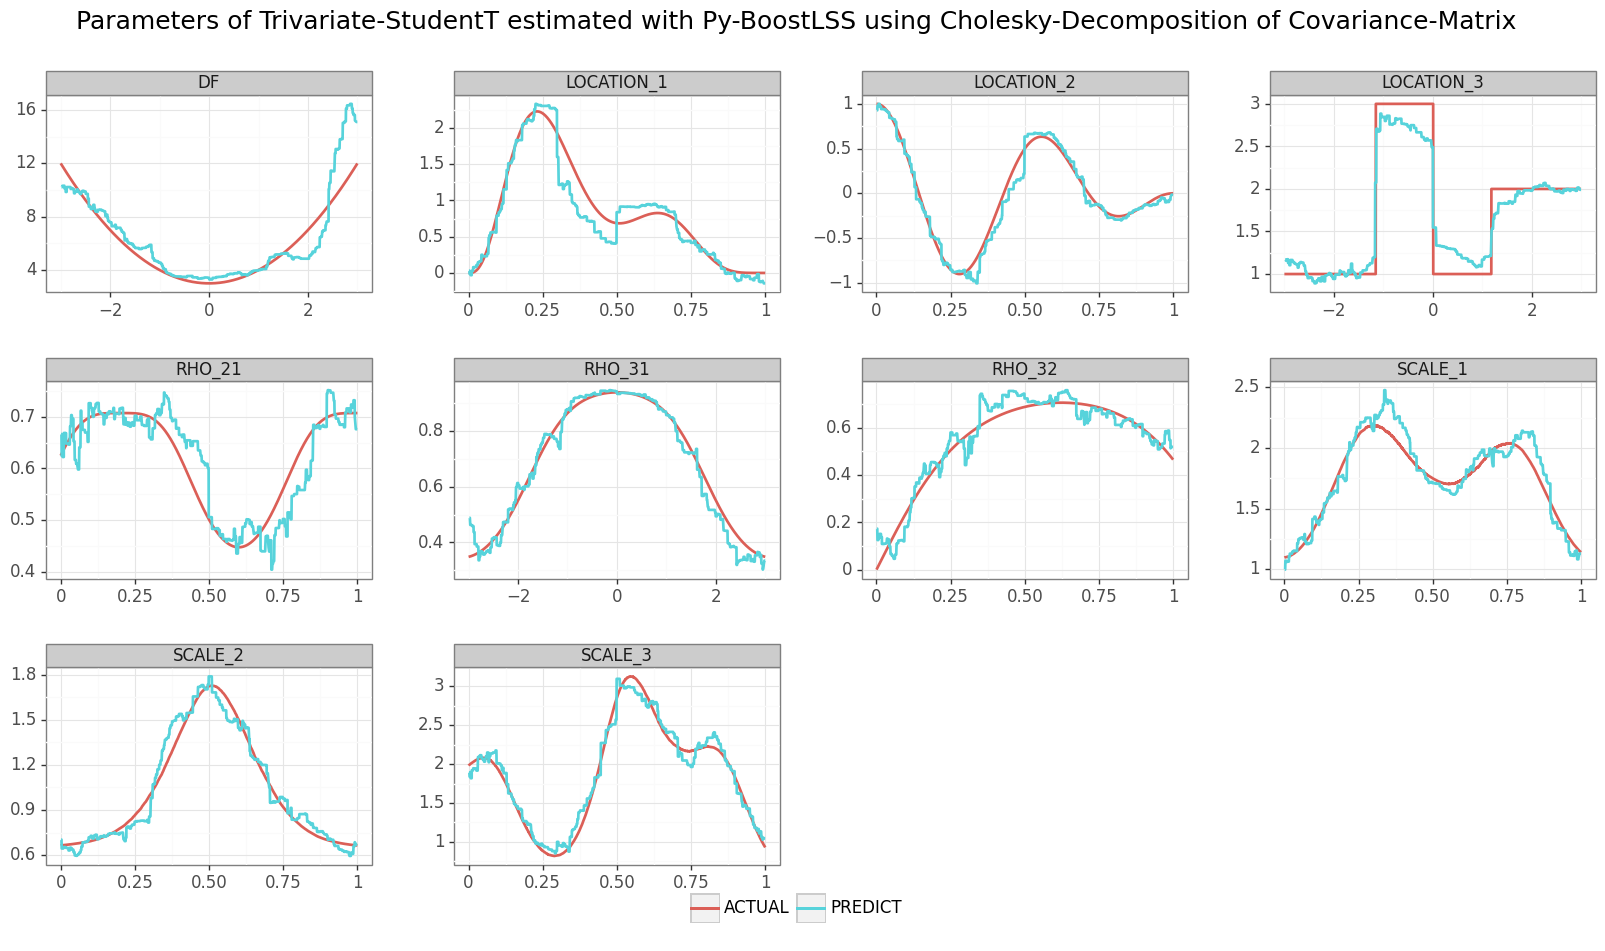

In [8]:
predt_params["x"] = x_test[:,0]
predt_params["x2"] = x_test[:,1]

# Data with actual values
plot_df_actual1 = pd.melt(test.drop(columns=["y1", "y2", "y3", "x2", "df", "location_3", "rho_31"], axis=0),
                          id_vars=["x"],
                          value_vars=["location_1", "location_2", "scale_1", "rho_21", "scale_2", "rho_32", "scale_3"])

plot_df_actual2 = pd.melt(test.drop(columns=["y1", "y2", "y3", "location_1", "location_2", "scale_1", "rho_21", "scale_2", "rho_32", "scale_3", "x"], axis=0),
                          id_vars=["x2"],
                          value_vars=["df", "location_3", "rho_31"])

plot_df_actual2.columns = list(plot_df_actual1.columns)
plot_df_actual = pd.concat([plot_df_actual1, plot_df_actual2])
plot_df_actual["type"] = "ACTUAL"



# Data with predicted values
plot_df_pred1 = pd.melt(predt_params.drop(columns=["x2", "df", "location_3", "rho_31"], axis=0),
                        id_vars=["x"],
                        value_vars=["location_1", "location_2", "scale_1", "rho_21", "scale_2", "rho_32", "scale_3"])

plot_df_pred2 = pd.melt(predt_params.drop(columns=["location_1", "location_2", "scale_1", "rho_21", "scale_2", "rho_32", "scale_3", "x"], axis=0),
                       id_vars=["x2"],
                       value_vars=["df", "location_3", "rho_31"])

plot_df_pred2.columns = list(plot_df_pred1.columns)
plot_df_predt= pd.concat([plot_df_pred1, plot_df_pred2])
plot_df_predt["type"] = "PREDICT"    


# Concatenated DF
plot_df = pd.concat([plot_df_actual, plot_df_predt])   
plot_df["variable"] = plot_df.variable.str.upper()


plot_params = (ggplot(plot_df,
                      aes(x="x",
                          y="value",
                          color="type")) +
               geom_line(size=1.1) + 
               facet_wrap("variable",
                          scales="free") + 
               labs(title="Parameters of Trivariate-StudentT estimated with Py-BoostLSS using Cholesky-Decomposition of Covariance-Matrix\n",
                    x="",
                    y="") + 
               theme_bw(base_size=15) + 
               theme(legend_position="bottom",
                     legend_title = element_blank(),
                     subplots_adjust={"wspace": 0.25,
                                      "hspace": 0.45})
              )


print(plot_params)

## Actuals vs. Predicted

Since we predict the entire conditional distribution, we can overlay the point predictions with predicted densities, from which we can also derive quantiles of interest.

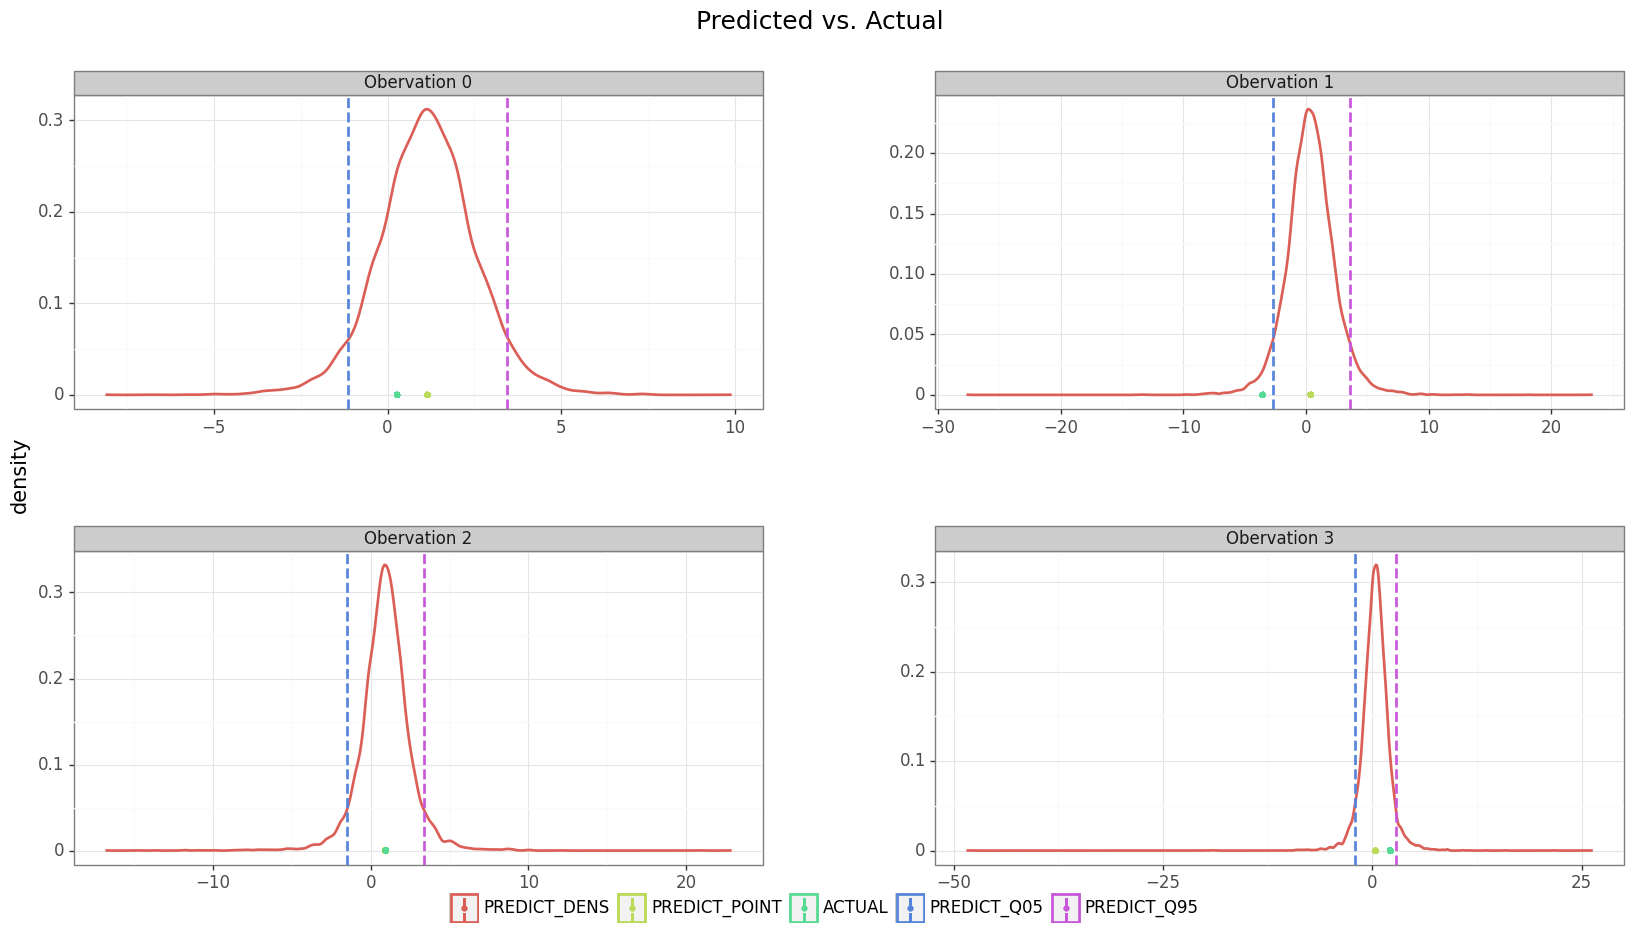

In [9]:
y_pred = []

n_examples = 4
q_sel = [0.05, 0.95]

for i in range(n_examples):
    
    y_samples = pd.DataFrame(predt_samples[:,i,0].reshape(-1,1), columns=["PREDICT_DENS"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENS"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENS"].quantile(q=q_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENS"].quantile(q=q_sel[1])
    y_samples["ACTUAL"] = y_test[i,0]
    y_samples["obs"]= f"Obervation {i}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free") + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          legend_title = element_blank(),
          subplots_adjust={"wspace": 0.25,
                           "hspace": 0.45})
)

print(plot_pred)